In [1]:
import os
import time
import glob
import sys
import random
import warnings

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images,imsave
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf
from tensorflow.python.client import device_lib

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

### ImageUtils

In [ ]:
class ImageUtils:

    '''
    Description : ImageUtils class to get the RGB, LAB and to split the LAB channel into L and AB
    '''

    # Method to get the RGB images
    @staticmethod
    def getRGBData(filePath, img_width, img_height):
        '''
        Description : 
                Method to get the RGB image from the given path
        Input :
                filePath => File path to the image (dType - String)
                img_width => Width of the Image 
                img_height => Height of the Image
        Returns :
                tf.Tensor 
        '''
        image = tf.io.read_file(filePath)
        image = tf.io.decode_jpeg(image)
        image = tf.image.resize(image, size=[img_width,img_height])
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = image / 255.0           # normalizing the image
        return image 

    # Method to get the LAB images
    @staticmethod
    def getLABData(image):
        '''
        Description : 
                Method to get the LAB image from the given image
        Input :
                image => RGB Image 
        Returns :
                tf.Tensor 
        '''
        pass
        # labImage = tfio.experimental.color.rgb_to_lab(image)
        # return labImage


    # # Method to get the training data
    # def getTrainingData(filePath):

    #     image = tf.io.read_file(filePath)
    #     image = tf.io.decode_jpeg(image)
    #     image = tf.image.convert_image_dtype(image, tf.float32)

    #     labImage = tfio.experimental.color.rgb_to_lab(image)

    #     return tf.reshape(labImage[:,:,0], shape=[256,256,1]), labImage[:,:,1:]


    # Method to get the X(L) and Y(AB) data
    @staticmethod
    def getXYData(labImage, img_width, img_height):
        '''
        Description : 
                Method to split LAB image into L and AB channels as X and Y
        Input :
                labImage => LAB Image
                img_width => Width of the Image 
                img_height => Height of the Image
        Returns :
                tf.Tensor, tf.Tensor 
        '''
        _l = tf.reshape(labImage[:,:,0], shape=[img_width,img_height,1])
        _ab = tf.reshape(labImage[:,:,1:] / 128, shape= [img_width,img_height,2])
        return _l, _ab

    # to fix the shape
    def fixup_shape(images):
        images.set_shape([None, None, None, 3])
        return images

### Test

_fn_test

In [ ]:
def printImageStatus(image, fileName):
    print(f'Image : {fileName}:')
    print(f'Shape : {image.shape}')
    print(f'Dtype : {image.dtype}')
    print('------------------------------')
    print('Min :')
    print(f'0 : {np.min(image[:,:,0])}')
    print(f'1 : {np.min(image[:,:,1])}')
    print(f'2 : {np.min(image[:,:,2])}')
    print('------------------------------')
    print('Max :')
    print(f'0 : {np.max(image[:,:,0])}')
    print(f'1 : {np.max(image[:,:,1])}')
    print(f'2 : {np.max(image[:,:,2])}')

In [ ]:
w = 256
h = 256

Testing

In [ ]:
imageFile = '/content/test4.jpg'

In [ ]:
image = imread(imageFile)

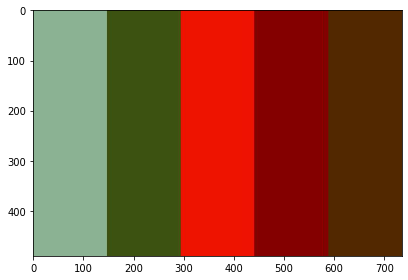

In [ ]:
imshow(image)

In [ ]:
printImageStatus(image,imageFile)

Image : /content/test4.jpg:
Shape : (490, 735, 3)
Dtype : uint8
------------------------------
Min :
0 : 56
1 : 0
2 : 0
------------------------------
Max :
0 : 247
1 : 183
2 : 147


In [ ]:
# resizing the image 
resizeImg = resize(image, output_shape=[w, h])

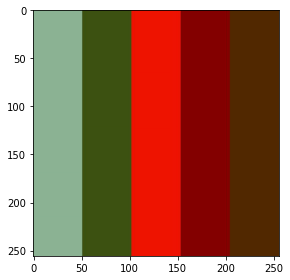

In [ ]:
imshow(resizeImg)

In [ ]:
printImageStatus(resizeImg, imageFile)

Image : /content/test4.jpg:
Shape : (256, 256, 3)
Dtype : float64
------------------------------
Min :
0 : 0.2273514093137255
1 : 0.0
2 : 0.0
------------------------------
Max :
0 : 0.9492493872549019
1 : 0.6980392156862745
2 : 0.5764705882352941


In [ ]:
# resize results in normalized image

In [ ]:
n_resizeImg = resizeImg * 1.0/255

In [ ]:
printImageStatus(n_resizeImg, imageFile)

Image : /content/test4.jpg:
Shape : (256, 256, 3)
Dtype : float64
------------------------------
Min :
0 : 0.0008915741541714725
1 : 0.0
2 : 0.0
------------------------------
Max :
0 : 0.00372254661668589
1 : 0.002737408688965782
2 : 0.0022606689734717416


In [ ]:
# converting the image to lab

In [ ]:
labImg = rgb2lab(resizeImg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


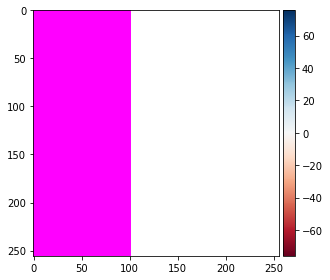

In [ ]:
imshow(labImg)

In [ ]:
printImageStatus(labImg,imageFile)

Image : /content/test4.jpg:
Shape : (256, 256, 3)
Dtype : float64
------------------------------
Min :
0 : 21.084521556878755
1 : -20.300371962314767
2 : 11.605825212679722
------------------------------
Max :
0 : 69.06555344325525
1 : 75.79553152372159
2 : 64.74873975401282


In [ ]:
_l = labImg[:,:,0]
_ab = labImg[:,:,1:]

In [ ]:
_l

array([[69.06555344, 69.06555344, 69.06555344, ..., 21.25220387,
        21.25220387, 21.25220387],
       [69.06555344, 69.06555344, 69.06555344, ..., 21.25220387,
        21.25220387, 21.25220387],
       [69.06555344, 69.06555344, 69.06555344, ..., 21.25220387,
        21.25220387, 21.25220387],
       ...,
       [69.06555344, 69.06555344, 69.06555344, ..., 21.25220387,
        21.25220387, 21.25220387],
       [69.06555344, 69.06555344, 69.06555344, ..., 21.25220387,
        21.25220387, 21.25220387],
       [69.06555344, 69.06555344, 69.06555344, ..., 21.25220387,
        21.25220387, 21.25220387]])

In [ ]:
(_ab + 128 ) / 255

array([[[0.42574825, 0.54747382],
        [0.42574825, 0.54747382],
        [0.42574825, 0.54747382],
        ...,
        [0.56762028, 0.6223169 ],
        [0.56762028, 0.6223169 ],
        [0.56762028, 0.6223169 ]],

       [[0.42574825, 0.54747382],
        [0.42574825, 0.54747382],
        [0.42574825, 0.54747382],
        ...,
        [0.56762028, 0.6223169 ],
        [0.56762028, 0.6223169 ],
        [0.56762028, 0.6223169 ]],

       [[0.42574825, 0.54747382],
        [0.42574825, 0.54747382],
        [0.42574825, 0.54747382],
        ...,
        [0.56762028, 0.6223169 ],
        [0.56762028, 0.6223169 ],
        [0.56762028, 0.6223169 ]],

       ...,

       [[0.42574825, 0.54747382],
        [0.42574825, 0.54747382],
        [0.42574825, 0.54747382],
        ...,
        [0.56762028, 0.6223169 ],
        [0.56762028, 0.6223169 ],
        [0.56762028, 0.6223169 ]],

       [[0.42574825, 0.54747382],
        [0.42574825, 0.54747382],
        [0.42574825, 0.54747382],
        .

In [ ]:
result = np.zeros((256,256,3))

In [ ]:
result[:,:,0] = (_l + 100) /255
result[:,:,1:] = (_ab + 128 ) / 255

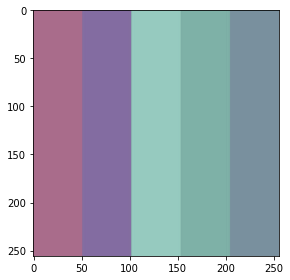

In [ ]:
imshow(result)

In [ ]:
ptsInHull = np.load('/content/pts_in_hull (1).npy')

In [ ]:
ptsInHull.shape

(313, 2)

In [ ]:
ptsInHull

array([[ -90,   50],
       [ -90,   60],
       [ -90,   70],
       [ -90,   80],
       [ -90,   90],
       [ -80,   20],
       [ -80,   30],
       [ -80,   40],
       [ -80,   50],
       [ -80,   60],
       [ -80,   70],
       [ -80,   80],
       [ -80,   90],
       [ -70,    0],
       [ -70,   10],
       [ -70,   20],
       [ -70,   30],
       [ -70,   40],
       [ -70,   50],
       [ -70,   60],
       [ -70,   70],
       [ -70,   80],
       [ -70,   90],
       [ -60,  -20],
       [ -60,  -10],
       [ -60,    0],
       [ -60,   10],
       [ -60,   20],
       [ -60,   30],
       [ -60,   40],
       [ -60,   50],
       [ -60,   60],
       [ -60,   70],
       [ -60,   80],
       [ -60,   90],
       [ -50,  -30],
       [ -50,  -20],
       [ -50,  -10],
       [ -50,    0],
       [ -50,   10],
       [ -50,   20],
       [ -50,   30],
       [ -50,   40],
       [ -50,   50],
       [ -50,   60],
       [ -50,   70],
       [ -50,   80],
       [ -50,

In [ ]:
prior = np.load('/content/prior_probs.npy')

In [ ]:
prior.shape

(313,)

In [ ]:
prior

array([4.88637077e-08, 1.38517899e-07, 5.76575330e-07, 2.63933821e-06,
       9.50312428e-07, 3.56691466e-08, 2.53701218e-07, 7.52531286e-07,
       1.96176670e-06, 3.01480592e-06, 4.88644584e-06, 5.64053403e-06,
       1.29429273e-06, 9.36679821e-08, 6.35391447e-07, 2.24641415e-06,
       5.25553580e-06, 8.76607414e-06, 1.34091655e-05, 1.82779229e-05,
       1.60724964e-05, 7.22202335e-06, 1.19142890e-06, 4.18887782e-07,
       1.88786671e-06, 5.56257122e-06, 1.39430890e-05, 2.40792026e-05,
       3.47403683e-05, 4.82280696e-05, 6.84466539e-05, 7.22763768e-05,
       4.29625157e-05, 1.64851003e-05, 3.02568434e-06, 7.73805166e-07,
       1.64461151e-05, 4.38741086e-05, 5.87340628e-05, 8.72316315e-05,
       1.18770632e-04, 1.67088961e-04, 2.63252494e-04, 3.38518453e-04,
       2.60347030e-04, 1.26975045e-04, 4.08961754e-05, 7.22817564e-06,
       1.99693873e-07, 8.92095222e-07, 2.17681063e-05, 1.12513049e-04,
       2.16379538e-04, 2.66030577e-04, 3.32276125e-04, 5.05886131e-04,
      

## Testing the image binning

In [ ]:
cv2Img = cv2.imread('/content/test9.jpg')

In [ ]:
cv2Img = cv2.resize(cv2Img, (224,224))

In [ ]:
cv2Lab = cv2.cvtColor(cv2Img, cv2.COLOR_BGR2LAB)

In [ ]:
cv2_imshow(cv2Lab)

NameError: ignored

In [ ]:
img = imread('/content/test9.jpg')

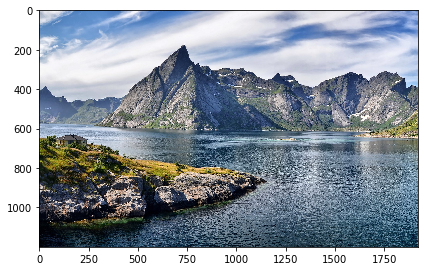

In [ ]:
imshow(img)

In [ ]:
img.shape

(1200, 1920, 3)

In [ ]:
img = resize(img, (224,224))

In [ ]:
img.shape

(224, 224, 3)

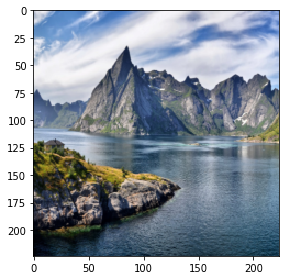

In [ ]:
imshow(img)

In [ ]:
lab = rgb2lab(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


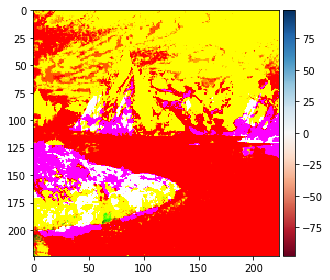

In [ ]:
imshow(lab)

In [ ]:
l = lab[:,:,0]
a = lab[:,:,1]
b = lab[:,:,2]

In [ ]:
print(f'L : ')
print(f'min : {np.min(l)} | max : {np.max(l)}')
print(f'A : ')
print(f'min : {np.min(a)} | max : {np.max(a)}')
print(f'B : ')
print(f'min : {np.min(b)} | max : {np.max(b)}')


L : 
min : 0.09893413517270844 | max : 97.58863439865962
A : 
min : -21.516313169761382 | max : 14.332910024077329
B : 
min : -43.75444130783419 | max : 58.861948665450704


In [ ]:
# rounding of the lab

In [ ]:
rlab = np.round(lab)

In [ ]:
rlab.dtype

dtype('float64')

In [ ]:
rlab = rlab.astype('float32')

In [ ]:
cv2Lab[:,:,0] = cv2Lab[:,:,0]
cv2Lab[:,:,1] = cv2Lab[:,:,1]
cv2Lab[:,:,2] = cv2Lab[:,:,2]

In [ ]:
x = cv2.calcHist(cv2Lab, [0], None, [313], [0,255])

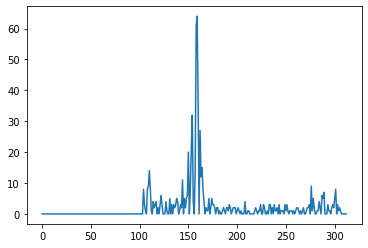

In [ ]:
plt.plot(x)

In [ ]:
x.ravel()

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        8.,  3.,  1.,  0.,  8.,  9., 14.,  8.,  1.,  0.,  4.,  2.,  3.,
        4.,  0.,  2.,  0.,  3.,  6.,  3.,  0.,  0.,  0.,  4.,  1.,  0.,
        0.,  5.,  0.,  3.,  0.,  3.,  2.,  3.,  5.,  4.,  0.,  1.,  3.,
        2., 11.,  0.,  5.,  2.,  5.,  6., 20.,  0.,  8., 21., 32.,  4.,
        0., 14., 61., 64., 36.,  0., 27., 12., 15.,  8.,  4.,  0.,  2.,
        1.,  1.,  5.,  0.,  2.,  5.,  3.,  3.,  2.,  0.,  2.,  2

In [ ]:
asd = imread('/content/test10.jpeg')

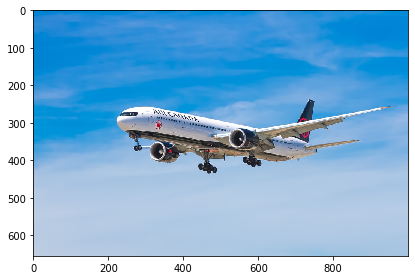

In [ ]:
imshow(asd)

In [ ]:
lab = rgb2lab(asd)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


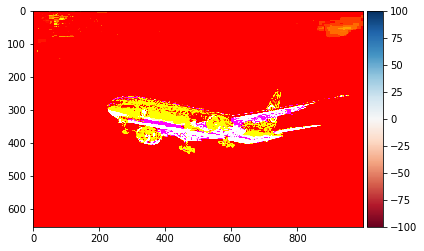

In [ ]:
imshow(lab)

In [ ]:
l = lab[:,:,0]

In [ ]:
l.shape

(655, 1000)

In [ ]:
gray = resize(l, (299, 299, 3), mode='constant')

In [ ]:
c = lab2rgb(gray)


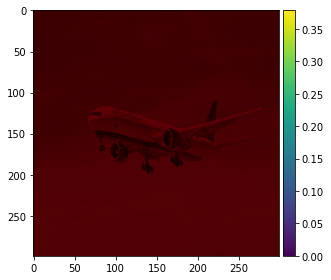

In [ ]:
imshow(c)

In [ ]:
z = preprocess_input(gray)

In [ ]:
z

array([[[-1.        , -0.64844575, -1.        ],
        [-1.        , -0.61802427, -1.        ],
        [-1.        , -0.61739496, -1.        ],
        ...,
        [-1.        , -0.59183196, -1.        ],
        [-1.        , -0.59396125, -1.        ],
        [-1.        , -0.62631598, -1.        ]],

       [[-1.        , -0.62163469, -1.        ],
        [-1.        , -0.58890146, -1.        ],
        [-1.        , -0.58888982, -1.        ],
        ...,
        [-1.        , -0.56128988, -1.        ],
        [-1.        , -0.56263759, -1.        ],
        [-1.        , -0.59747742, -1.        ]],

       [[-1.        , -0.62162756, -1.        ],
        [-1.        , -0.58887615, -1.        ],
        [-1.        , -0.58746081, -1.        ],
        ...,
        [-1.        , -0.56179601, -1.        ],
        [-1.        , -0.56197129, -1.        ],
        [-1.        , -0.59685067, -1.        ]],

       ...,

       [[-1.        , -0.40928771, -1.        ],
        [-1

In [14]:
from google.colab.patches import cv2_imshow

In [5]:
out_img_rows = 64
out_img_cols = 64

In [13]:
bgr = cv2.imread('/content/test10.jpeg')
# bgr = cv2.resize(bgr, (img_rows, img_cols), cv2.INTER_CUBIC)
gray = cv2.imread('/content/test10.jpeg', 0)
# gray = cv2.resize(gray, (img_rows, img_cols), cv2.INTER_CUBIC)
lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
x = gray / 255.

out_lab = cv2.resize(lab, (out_img_rows, out_img_cols), cv2.INTER_CUBIC)
# Before: 42 <=a<= 226, 20 <=b<= 223
# After: -86 <=a<= 98, -108 <=b<= 95
out_ab = out_lab[:, :, 1:].astype(np.int32) - 128


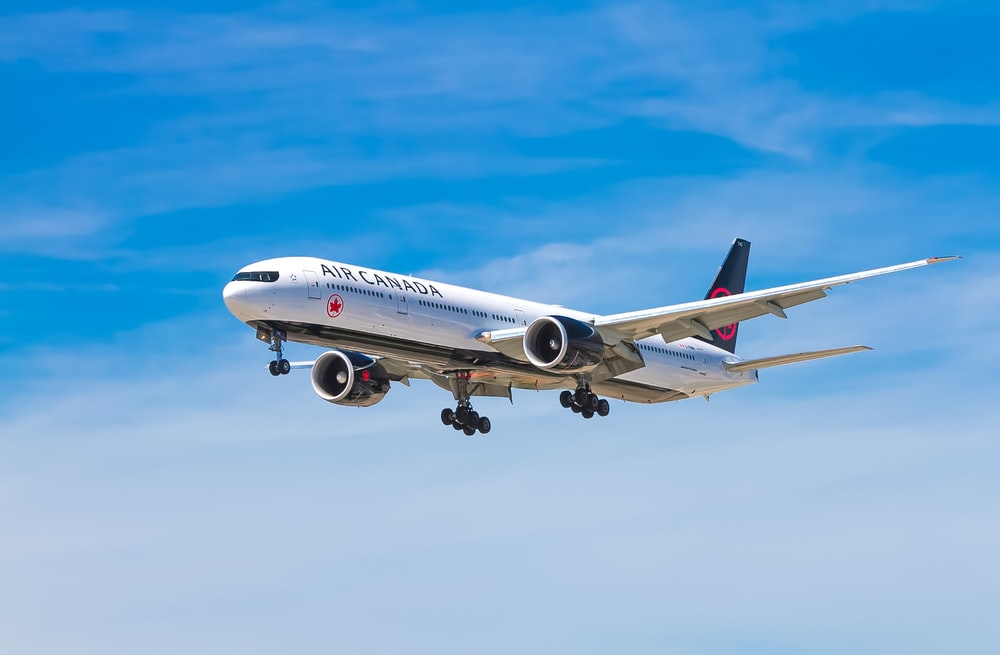

In [15]:
cv2_imshow(bgr)

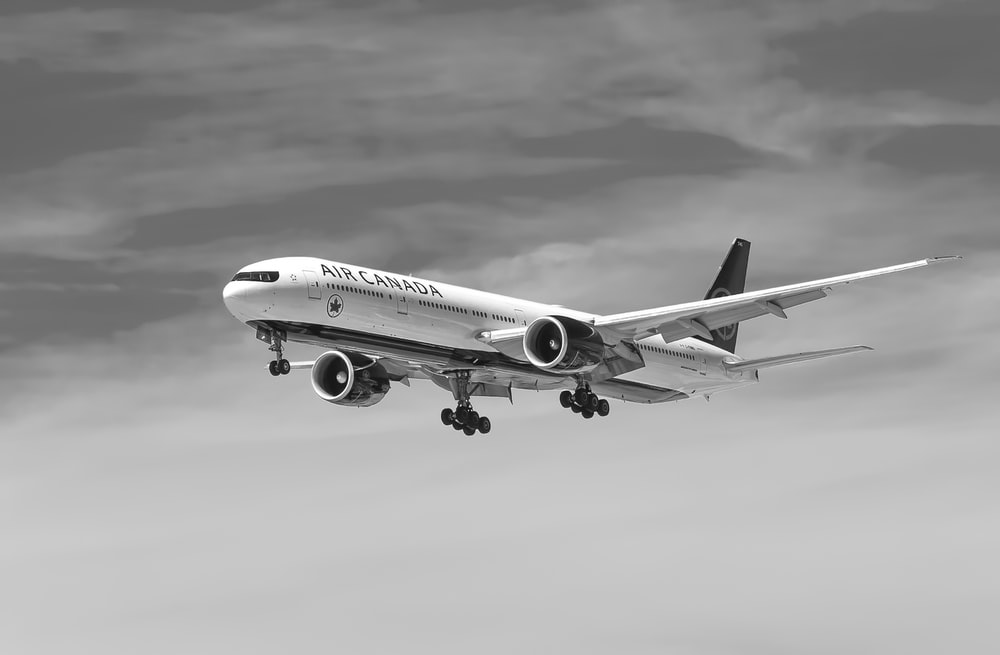

In [16]:
cv2_imshow(gray)

In [18]:
out_ab

array([[[  0, -48],
        [ -1, -48],
        [  0, -49],
        ...,
        [ -4, -47],
        [ -4, -47],
        [ -4, -48]],

       [[ -1, -48],
        [ -1, -48],
        [  0, -48],
        ...,
        [ -2, -48],
        [ -2, -48],
        [ -2, -48]],

       [[ -1, -47],
        [  0, -47],
        [ -1, -46],
        ...,
        [  0, -50],
        [  0, -50],
        [  0, -50]],

       ...,

       [[ -2, -12],
        [ -1, -13],
        [ -2, -13],
        ...,
        [ -3, -17],
        [ -3, -17],
        [ -3, -17]],

       [[ -1, -12],
        [ -2, -12],
        [ -2, -13],
        ...,
        [ -4, -17],
        [ -4, -17],
        [ -4, -17]],

       [[ -1, -11],
        [ -1, -12],
        [ -2, -12],
        ...,
        [ -4, -17],
        [ -4, -17],
        [ -4, -17]]], dtype=int32)